In [1]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

from sklearn.metrics import f1_score

print(torch.cuda.device_count())

#np.random.seed(seed=1)
#L.seed_everything(seed=1, workers=True)

1


### Define the list of variables from the h5 file to use as features, spectator and labels

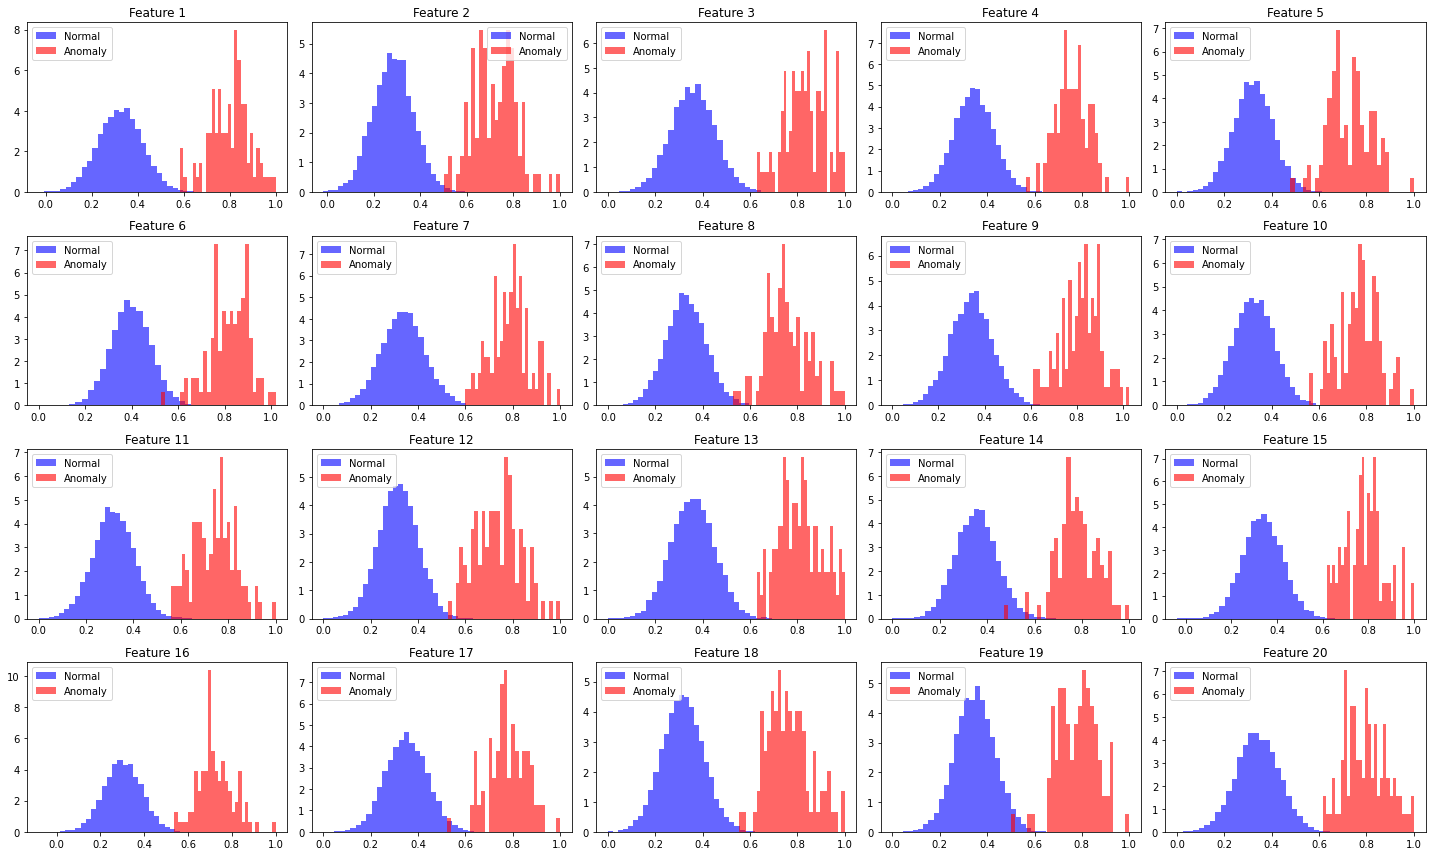

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Generate synthetic data ===
n_samples = 12000
dim = 20


n_anomaly = 100
normal_ratio = (n_samples - n_anomaly) / n_samples
n_normal = int(n_samples * normal_ratio)

# Generate different means for each normal feature, e.g., between -2 and +2
normal_means = np.linspace(-2, 2, dim)  

# Normal data: each feature Gaussian with different mean, sigma=1
normal_data = np.random.normal(loc=normal_means, scale=1.0, size=(n_normal, dim))

# Anomaly data: shift mean by +5 sigma above normal means
anomaly_means = normal_means + 5  # 5 sigma above normal means
anomaly_data = np.random.normal(loc=anomaly_means, scale=1.0, size=(n_anomaly, dim))

# Combine data and labels
X = np.vstack([normal_data, anomaly_data])
y = np.hstack([np.zeros(n_normal), np.ones(n_anomaly)])

# === 2. Train/test split with stratification ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y
)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# === 3. Scale features ===
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

# === 4. Further split train into train/validation (optional) ===
ae_train, ae_valid = train_test_split(
    train_scaled, test_size=0.20, random_state=1, shuffle=True
)

# === 5. Plot feature distributions ===
X_scaled = np.vstack([train_scaled, test_scaled])
y_all = np.hstack([y_train, y_test])

n_features = X_scaled.shape[1]
n_rows, n_cols = 4, 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

for i in range(n_features):
    ax = axes[i]
    feature_normal = X_scaled[y_all == 0, i]
    feature_anomaly = X_scaled[y_all == 1, i]

    ax.hist(feature_normal, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
    ax.hist(feature_anomaly, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
    ax.set_title(f'Feature {i+1}')
    ax.legend()

for j in range(n_features, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [19]:
scaler = MinMaxScaler()

train = scaler.fit_transform(X_train)
test = scaler.transform(X_test)


In [20]:
test.size

36000

In [21]:
class Autoencoder(L.LightningModule):
    def __init__(self, in_dim=20, latent_dim=4, dropout_rate=0.1):
        super().__init__()
        self.save_hyperparameters()

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 12),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(12, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.01),

            nn.Linear(8, latent_dim)  # bottleneck 4
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(8, 12),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(0.01),

            nn.Linear(12, in_dim)  # reconstruction 18
        )

        self.encoder.apply(init_weights)
        self.decoder.apply(init_weights)

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def compute_loss(self, x, x_reconstructed):
        return F.mse_loss(x_reconstructed, x)

    def training_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = self.compute_loss(input, output)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = self.compute_loss(input, output)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        return self.forward(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5, verbose=True
            ),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


#### PyTorch Progress Bar Implementation

In [22]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

In [23]:

model = Autoencoder(in_dim=train.shape[1])

batch_size = 32  # increase if GPU allows

ae_train, ae_valid = train_test_split(train, test_size=0.20, random_state=1, shuffle=True)
ae_train_ds, ae_val_ds, ae_test_ds = SensorDataset(ae_train), SensorDataset(ae_valid), SensorDataset(test)
ae_tdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4)
ae_vdl = DataLoader(ae_val_ds, batch_size=batch_size, num_workers=4)
ae_testdl = DataLoader(ae_test_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()

trainer = L.Trainer(
    callbacks=[pb, es, cp],
    max_epochs=20,
    logger=False,
    enable_checkpointing=True,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=1.0  # added for stability
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:

trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)


/eos/user/c/castaned/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /eos/home-i04/c/castaned/VAE_training/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 432    | train
1 | decoder | Sequential | 448    | train
-----------------------------------------------
880       Trainable params
0         Non-trainable params
880       Total params
0.004     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
Epoch 20: 100%|██████████| 255/255 [00:02<00:00, 100.22it/s, loss=0.0185, val_loss=0.0143]


### Loss curve

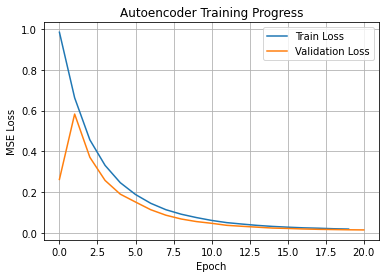

In [25]:
plt.plot(model.training_losses, label='Train Loss')
plt.plot(model.validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
len(ae_testdl.dataset)

1800

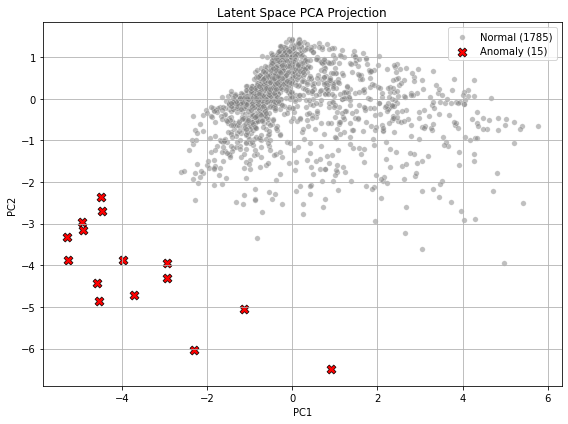

Normal samples: 1785
Anomaly samples: 15


In [27]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        latent_vectors.append(z.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

# Ensure y_test is numpy array and aligned with latent vectors
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()

y_test_aligned = y_test[:latent_vectors.shape[0]]

# Map binary labels to strings for plotting
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

# PCA projection
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Prepare DataFrame for plotting
df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels
})

# Count samples per label
counts = df['Label'].value_counts().to_dict()
normal_label = f"Normal ({counts.get('Normal', 0)})"
anomaly_label = f"Anomaly ({counts.get('Anomaly', 0)})"

# Plot
plt.figure(figsize=(8,6))

# Normal points
sns.scatterplot(
    data=df[df['Label'] == 'Normal'],
    x='PC1', y='PC2',
    label=normal_label,
    color='gray',
    alpha=0.5,
    s=30
)

# Anomaly points
sns.scatterplot(
    data=df[df['Label'] == 'Anomaly'],
    x='PC1', y='PC2',
    label=anomaly_label,
    color='red',
    marker='X',
    s=80,
    edgecolor='black'
)

plt.title('Latent Space PCA Projection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print counts
print(f"Normal samples: {counts.get('Normal', 0)}")
print(f"Anomaly samples: {counts.get('Anomaly', 0)}")



In [28]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

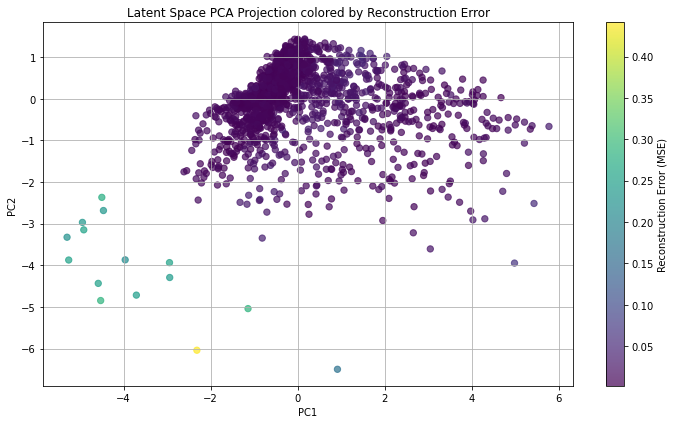

In [29]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
reconstruction_errors = []
inputs_all = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        outputs = model.decoder(z)
        
        # Compute per-sample MSE error (assumes batch shape [B, features])
        batch_errors = F.mse_loss(outputs, batch, reduction='none')
        batch_errors = batch_errors.mean(dim=1)  # mean over features
        
        latent_vectors.append(z.cpu())
        reconstruction_errors.append(batch_errors.cpu())
        inputs_all.append(batch.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
reconstruction_errors = torch.cat(reconstruction_errors, dim=0).numpy()

# Align labels
if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test
y_test_aligned = y_test_np[:latent_vectors.shape[0]]

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Build DataFrame with PCA coords, labels, and error
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels,
    'ReconError': reconstruction_errors
})

# Plot: PCA scatter colored by reconstruction error
plt.figure(figsize=(10,6))
scatter = plt.scatter(df['PC1'], df['PC2'], c=df['ReconError'], cmap='viridis', alpha=0.7, s=40)
plt.colorbar(scatter, label='Reconstruction Error (MSE)')
plt.title('Latent Space PCA Projection colored by Reconstruction Error')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
"""
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
reconstruction_errors = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        outputs = model.decoder(z)

        # MSE reconstruction error per sample
        batch_errors = F.mse_loss(outputs, batch, reduction='none').mean(dim=1)
        latent_vectors.append(z.cpu())
        reconstruction_errors.append(batch_errors.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
reconstruction_errors = torch.cat(reconstruction_errors, dim=0).numpy()

# Align y_test with latent_vectors
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()
y_test_aligned = y_test[:latent_vectors.shape[0]]
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

# PCA projection
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Create DataFrame
df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels,
    'ReconError': reconstruction_errors
})

# Normalize reconstruction error for visual scaling (optional)
error_norm = (df['ReconError'] - df['ReconError'].min()) / (df['ReconError'].max() - df['ReconError'].min())
df['ErrorSize'] = 30 + 170 * error_norm  # scale size: 30–200

# Plot: color = label, size = reconstruction error
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='PC1', y='PC2',
    hue='Label',
    size='ErrorSize',
    sizes=(30, 200),
    alpha=0.7,
    palette={'Normal': 'gray', 'Anomaly': 'red'},
    edgecolor='black',
    legend='brief'
)

plt.title('Latent Space PCA: Color = Label, Size = Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: also print counts
counts = df['Label'].value_counts().to_dict()
print(f"Normal samples: {counts.get('Normal', 0)}")
print(f"Anomaly samples: {counts.get('Anomaly', 0)}")


SyntaxError: incomplete input (2982947629.py, line 1)

In [31]:
"""
# --- t-SNE visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], s=10, alpha=0.7)
plt.title('Latent Space t-SNE Projection')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- KMeans clustering (on original latent vectors) ---
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

# Plot clusters on PCA
plt.figure(figsize=(8,6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Plot clusters on t-SNE
plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space t-SNE')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- Correlation heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.show()

SyntaxError: incomplete input (2336642069.py, line 1)

In [32]:
"""
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import animation

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
inputs = []
recon_errors = []
time_steps = []  # Optional: fill if you have time info

# --- Inference Loop ---
with torch.no_grad():
    for i, batch in enumerate(ae_vdl):
        batch = batch.to(device)
        z = model.encoder(batch)
        recon = model.decoder(z)
        loss = torch.nn.functional.mse_loss(recon, batch, reduction='none')
        per_sample_mse = loss.view(loss.size(0), -1).mean(dim=1)

        latent_vectors.append(z.cpu())
        inputs.append(batch.cpu())
        recon_errors.append(per_sample_mse.cpu())
        time_steps.extend([i] * batch.size(0))  # Optional

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
inputs = torch.cat(inputs, dim=0).numpy()
recon_errors = torch.cat(recon_errors, dim=0).numpy()
time_steps = np.array(time_steps)  # Optional

# --- Scatter plot with reconstruction error ---
plt.figure(figsize=(8,6))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                 c=recon_errors, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(sc, label='Reconstruction Error (MSE)')
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- KMeans Clustering ---
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=clusters, cmap='tab10', s=15, alpha=0.8)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clustering (k={n_clusters}) in Latent Space')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- Correlation Heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.tight_layout()
plt.show()


SyntaxError: incomplete input (3762970052.py, line 1)

In [33]:
"""
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Range of k values to try
k_range = range(2, 11)

best_k = None
best_score = -1
best_labels = None

for k in k_range:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(latent_vectors) + (k + 1) * 10])

    # Apply KMeans and compute silhouette scores
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    silhouette_avg = silhouette_score(latent_vectors, cluster_labels)
    sample_silhouette_values = silhouette_samples(latent_vectors, cluster_labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k
        best_labels = cluster_labels

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing

    ax1.set_title(f"Silhouette Plot for k={k}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1.0, 6))
    plt.tight_layout()
    plt.show()

print(f"✅ Optimal number of clusters: {best_k} (Silhouette score: {best_score:.3f})")

SyntaxError: incomplete input (3658066858.py, line 1)

In [34]:
"""
plt.figure(figsize=(8, 6))
plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=best_labels,
    cmap='tab10',
    s=15,
    alpha=0.8,
    edgecolor='k'
)
plt.title(f'Latent Space Colored by KMeans Clusters (k={best_k})')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()


SyntaxError: incomplete input (4185687856.py, line 1)

### AE Result Visualization

In [35]:
"""
import torch.nn.functional as F

# Recompute reconstructions
with torch.no_grad():
    latent_tensor = torch.tensor(latent_vectors).to(device).float()
    reconstructions = model.decoder(latent_tensor).cpu()

# Compute reconstruction error (MSE per sample)
reconstruction_errors = F.mse_loss(torch.tensor(inputs), reconstructions, reduction='none')
reconstruction_errors = reconstruction_errors.mean(dim=1).numpy()

# Scatter plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=reconstruction_errors,
    cmap='viridis',
    s=15,
    alpha=0.8
)
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(sc, label='Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()


SyntaxError: incomplete input (2534844865.py, line 1)

In [36]:
"""
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    'Latent_1': latent_vectors[:, 0],
    'Latent_2': latent_vectors[:, 1],
    'Reconstruction_Error': reconstruction_errors
})

fig = px.scatter(
    df,
    x='Latent_1',
    y='Latent_2',
    color='Reconstruction_Error',
    color_continuous_scale='Viridis',
    title='Latent Space Colored by Reconstruction Error (Interactive)',
    hover_data=['Reconstruction_Error'],
    width=800,
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(coloraxis_colorbar=dict(title="Reconstruction<br>Error"))
fig.show()


SyntaxError: incomplete input (760246372.py, line 1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


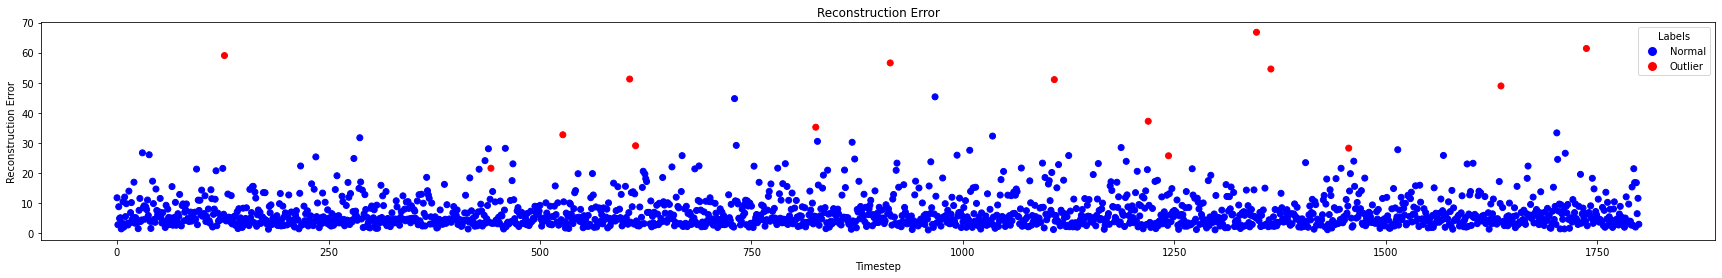

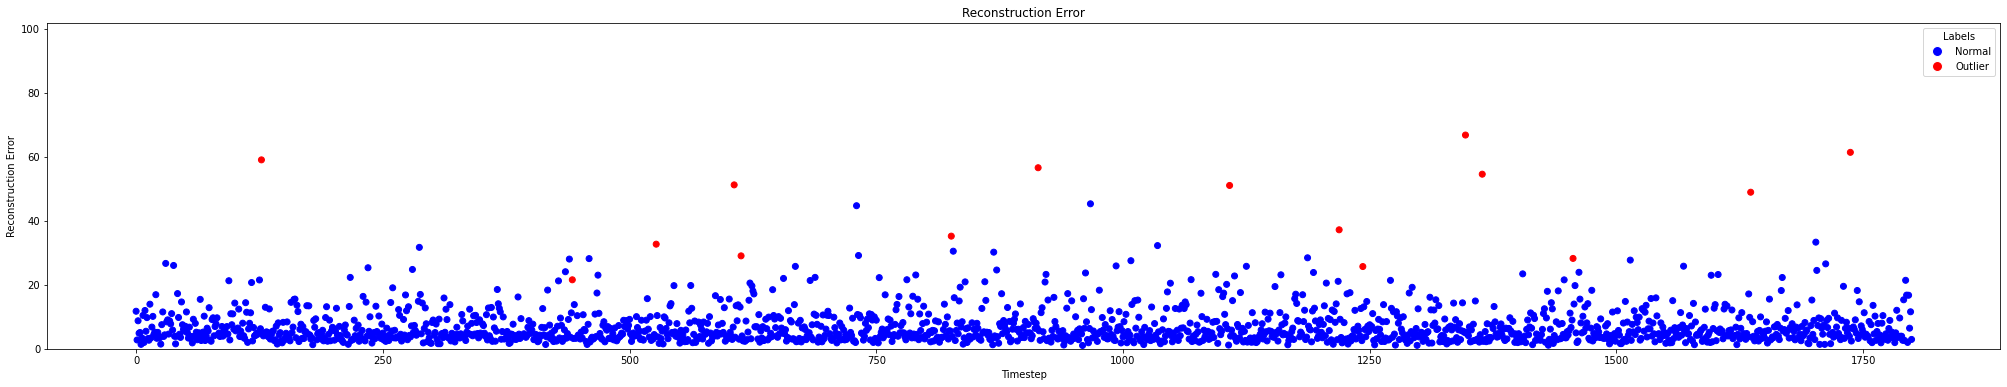

In [46]:

test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by AE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 20)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

In [38]:
"""
# Solo outliers (label == 1)
outlier_indices = y_test == 1

plt.figure(figsize=(30, 4))
plt.scatter(np.where(outlier_indices)[0], reco[outlier_indices], c=test_label_colors[outlier_indices],
            label='Reconstruction Error (Outliers)')
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error (Only Outliers)')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

SyntaxError: incomplete input (3831449403.py, line 1)

In [ ]:
"""
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, reco)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Autoencoder')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()